In [70]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, LeaveOneOut, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.utils import resample
import seaborn as sns
import matplotlib.pyplot as plt


df1 = pd.read_csv('Data_Class_1.csv')
df2 = pd.read_csv('Data_Class_2.csv')
df3 = pd.read_csv('Data_Class_3.csv')

df = pd.concat([df1, df2, df3], axis=0)

df.reset_index(drop=True, inplace=True)

print(df.head())


   Id  Altitude  Slope_Orientation  Slope  Horizontal_Distance_To_Water  \
0  41      2699                347      3                             0   
1  52      2739                323     25                            85   
2  53      2696                 72      2                            30   
3  56      2722                315     24                            30   
4  68      2919                 13     13                            90   

   Vertical_Distance_To_Water  Horizontal_Distance_To_Roadways  \
0                           0                             2096   
1                          43                             3118   
2                           0                             3271   
3                          19                             3216   
4                           6                             5321   

   Shadow_Index_9h  Shadow_Index_12h  Shadow_Index_15h  \
0              213               234               159   
1              149               205

In [71]:
df.shape

(5184, 18)

In [72]:
# Generate descriptive statistics for the dataset
print(df.describe())


                 Id     Altitude  Slope_Orientation        Slope  \
count   5184.000000  5184.000000        5184.000000  5184.000000   
mean    7510.204861  2843.550926         161.878665    15.517554   
std     4624.413034   357.981922         111.928353     8.307825   
min        3.000000  1903.000000           0.000000     1.000000   
25%     2978.500000  2561.750000          63.000000     9.000000   
50%     8273.500000  2935.000000         137.000000    14.000000   
75%    11262.250000  3136.250000         271.000000    21.000000   
max    15118.000000  3675.000000         360.000000    47.000000   

       Horizontal_Distance_To_Water  Vertical_Distance_To_Water  \
count                   5184.000000                 5184.000000   
mean                     256.798997                   49.864198   
std                      199.066593                   57.863126   
min                        0.000000                 -146.000000   
25%                      108.000000                 

In [73]:
data_info = pd.DataFrame({
    'Data Type': df.dtypes,
    'Missing Values': df.isnull().sum(),
    'Unique Values': df.nunique()
})

data_info

,Data Type,Missing Values,Unique Values
Id,int64,0,5184
Altitude,int64,0,1359
Slope_Orientation,int64,0,361
Slope,int64,0,46
Horizontal_Distance_To_Water,int64,0,290
Vertical_Distance_To_Water,int64,0,338
Horizontal_Distance_To_Roadways,int64,0,2346
Shadow_Index_9h,int64,0,170
Shadow_Index_12h,int64,0,127
Shadow_Index_15h,int64,0,232


Plot histograms for all numerical columns, to bezzer understand their distributions.

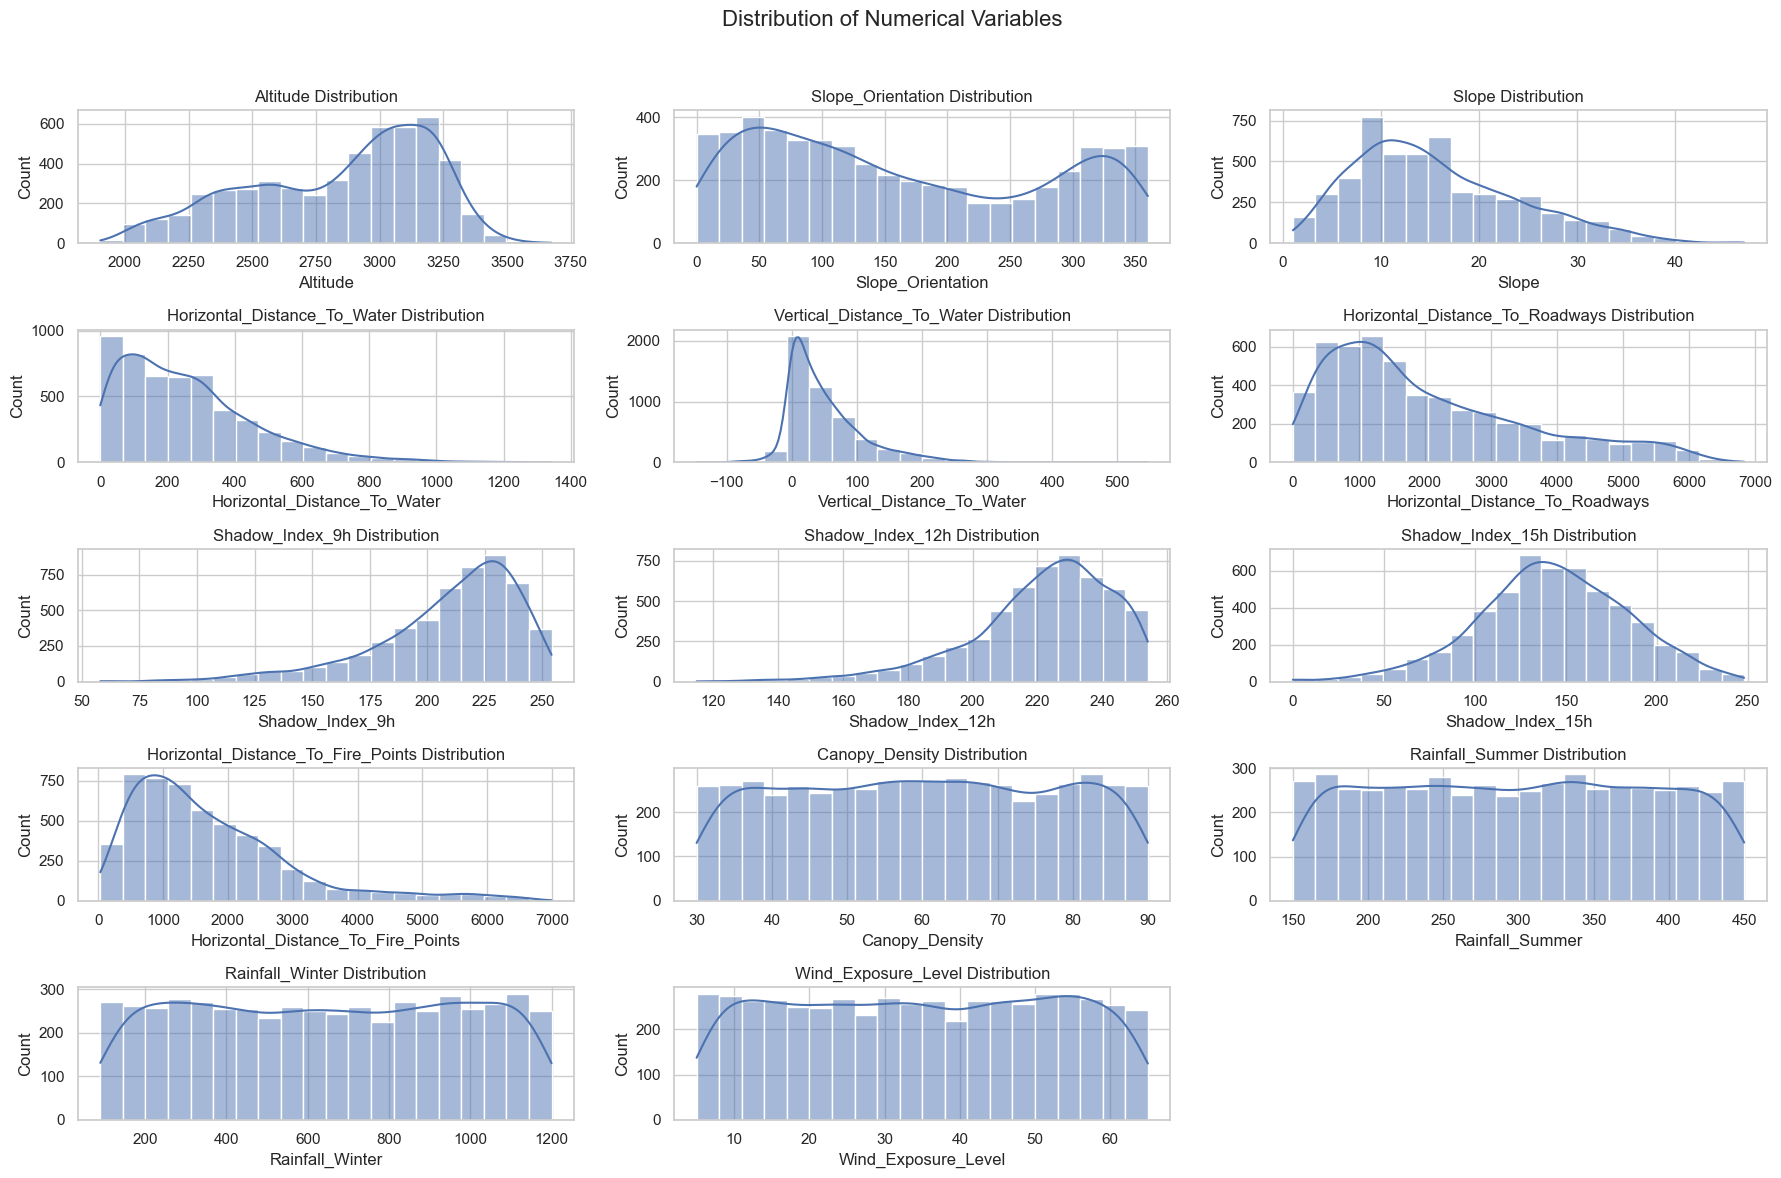

In [74]:

sns.set(style="whitegrid")

# List of numerical columns to plot
numerical_columns = [
    'Altitude', 'Slope_Orientation', 'Slope', 
    'Horizontal_Distance_To_Water', 'Vertical_Distance_To_Water', 
    'Horizontal_Distance_To_Roadways', 'Shadow_Index_9h', 
    'Shadow_Index_12h', 'Shadow_Index_15h', 
    'Horizontal_Distance_To_Fire_Points', 'Canopy_Density', 
    'Rainfall_Summer', 'Rainfall_Winter', 'Wind_Exposure_Level'
]

# Set up the subplots, adjusting number of rows and columns to fit all features
num_plots = len(numerical_columns)
cols = 3
rows = num_plots // cols + (num_plots % cols > 0)

fig, axes = plt.subplots(rows, cols, figsize=(18, 12))
fig.suptitle('Distribution of Numerical Variables', fontsize=16)

# Plot histograms for each numerical feature
for i, col in enumerate(numerical_columns):
    row = i // cols
    col_idx = i % cols
    sns.histplot(df[col], kde=True, bins=20, ax=axes[row, col_idx])
    axes[row, col_idx].set_title(f'{col} Distribution')

# Hide any unused subplots
for i in range(num_plots, rows * cols):
    fig.delaxes(axes.flat[i])

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


Here we can see distribution of various numerical variables using histograms. Each plot visualizes how the data is spread for features such as Altitude, Slope Orientation, Slope, and more. The density curves (where applicable) help indicate the shape of these distributions. For instance, Altitude and Slope Orientation exhibit fairly normal distributions, while variables like Vertical Distance to Water show skewed distributions.



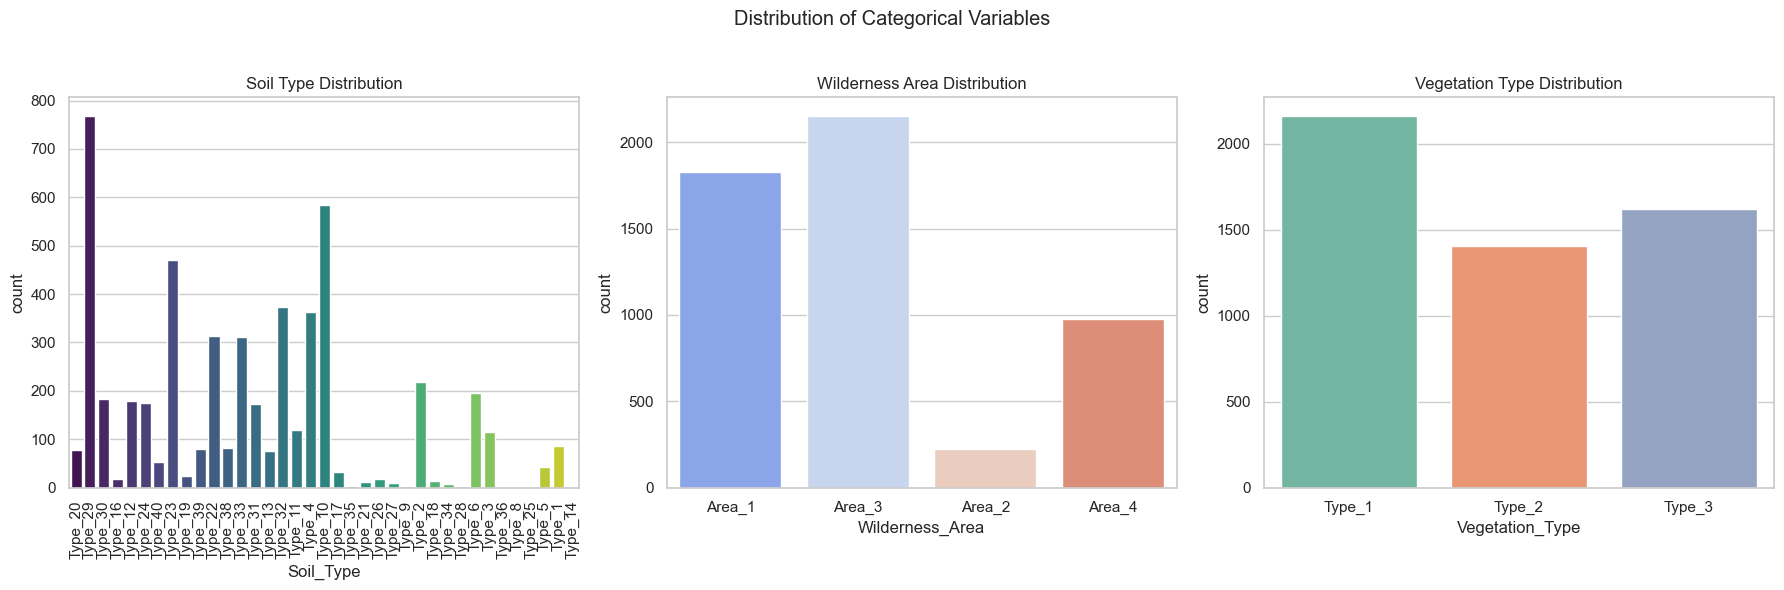

In [75]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style for the visualizations
sns.set(style="whitegrid")

# Plot bar plots for categorical variables
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Distribution of Categorical Variables')

# Plot for Soil_Type
sns.countplot(data=df, x='Soil_Type', hue='Soil_Type', ax=axes[0], palette='viridis', legend=False)
axes[0].set_title('Soil Type Distribution')
axes[0].tick_params(axis='x', rotation=90)  # Rotate labels if needed

# Plot for Wilderness_Area
sns.countplot(data=df, x='Wilderness_Area', hue='Wilderness_Area', ax=axes[1], palette='coolwarm', legend=False)
axes[1].set_title('Wilderness Area Distribution')

# Plot for Vegetation_Type
sns.countplot(data=df, x='Vegetation_Type', hue='Vegetation_Type', ax=axes[2], palette='Set2', legend=False)
axes[2].set_title('Vegetation Type Distribution')

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


Graphs for bivariate analysis, to see scatter plots between the numerical variables and target variable to observe any trends or patters.

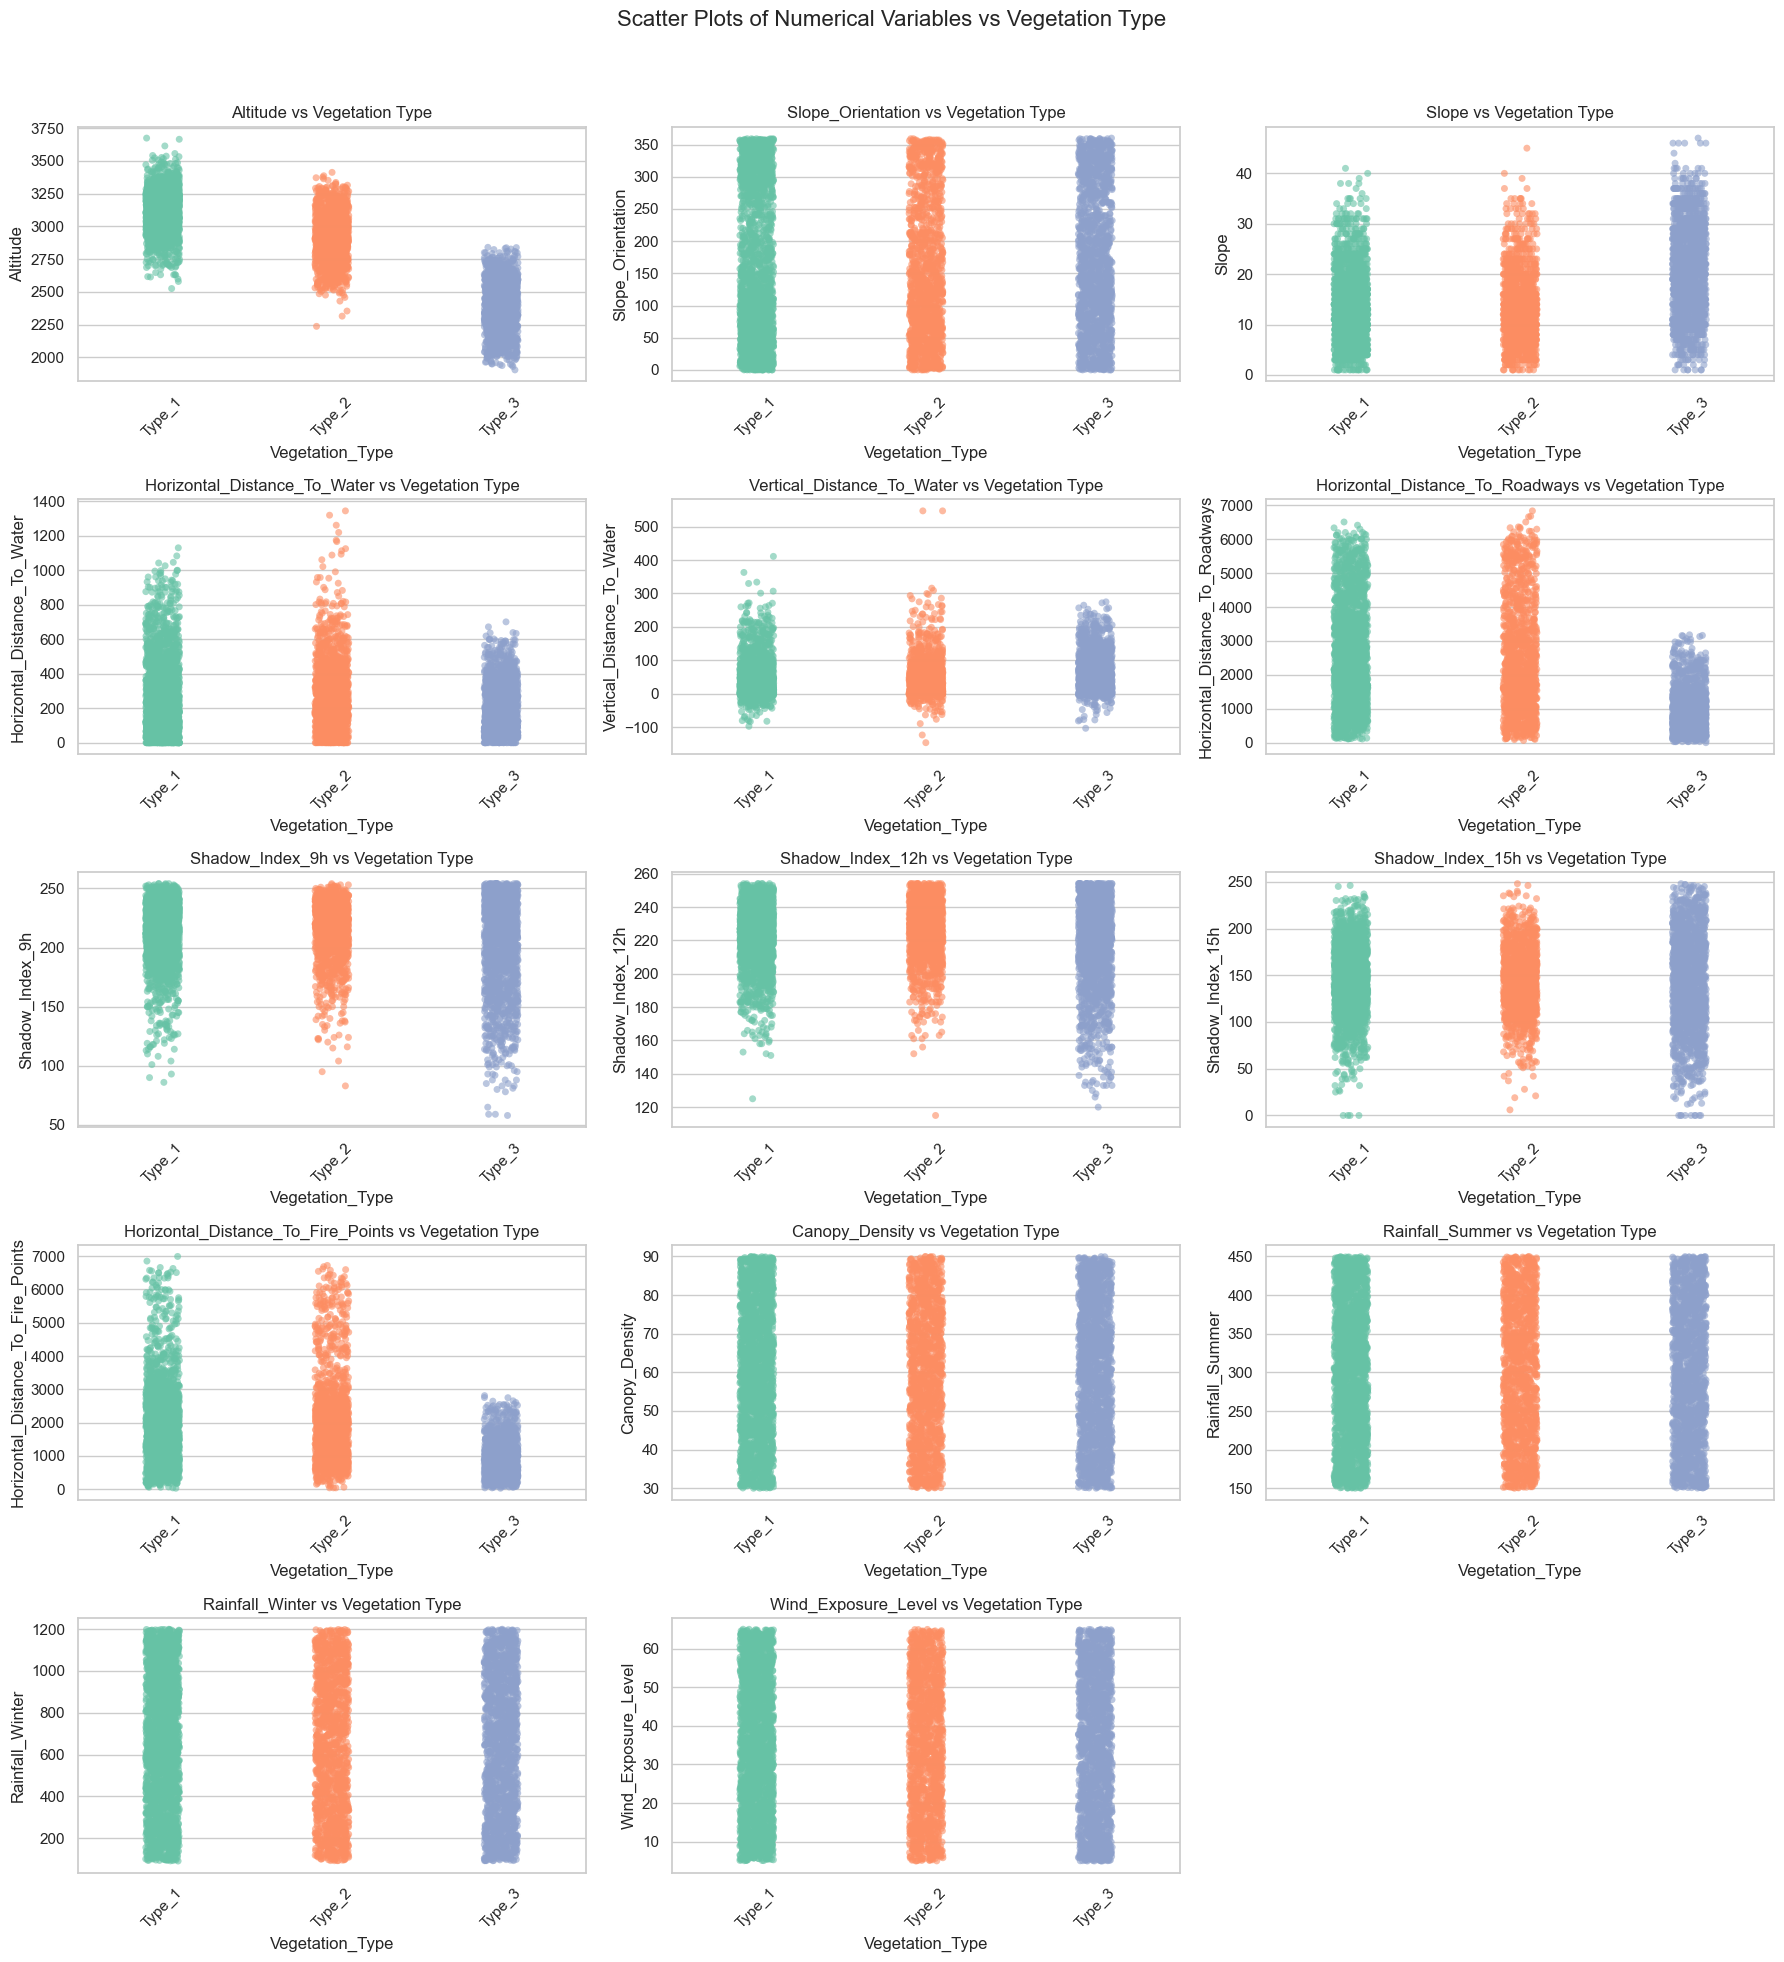

In [76]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style for the visualizations
sns.set(style="whitegrid")

# List of numerical variables to plot against Vegetation_Type
numerical_columns = [
    'Altitude', 'Slope_Orientation', 'Slope', 
    'Horizontal_Distance_To_Water', 'Vertical_Distance_To_Water', 
    'Horizontal_Distance_To_Roadways', 'Shadow_Index_9h', 
    'Shadow_Index_12h', 'Shadow_Index_15h', 
    'Horizontal_Distance_To_Fire_Points', 'Canopy_Density', 
    'Rainfall_Summer', 'Rainfall_Winter', 'Wind_Exposure_Level'
]

# Set up the subplots grid
num_plots = len(numerical_columns)
cols = 3  # Number of columns
rows = num_plots // cols + (num_plots % cols > 0)  # Number of rows

fig, axes = plt.subplots(rows, cols, figsize=(18, 4 * rows))
fig.suptitle('Scatter Plots of Numerical Variables vs Vegetation Type', fontsize=16)

# Plot each numerical variable vs Vegetation_Type
for i, col in enumerate(numerical_columns):
    row = i // cols
    col_idx = i % cols
    # Use stripplot for jitter effect or scatterplot directly
    sns.stripplot(x='Vegetation_Type', y=col, data=df, ax=axes[row, col_idx], jitter=True, palette='Set2', hue='Vegetation_Type', alpha=0.6, legend=False)
    axes[row, col_idx].set_title(f'{col} vs Vegetation Type')
    axes[row, col_idx].tick_params(axis='x', rotation=45)  # Rotate x labels for readability

# Hide any empty subplots (if any)
for i in range(num_plots, rows * cols):
    fig.delaxes(axes.flat[i])

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


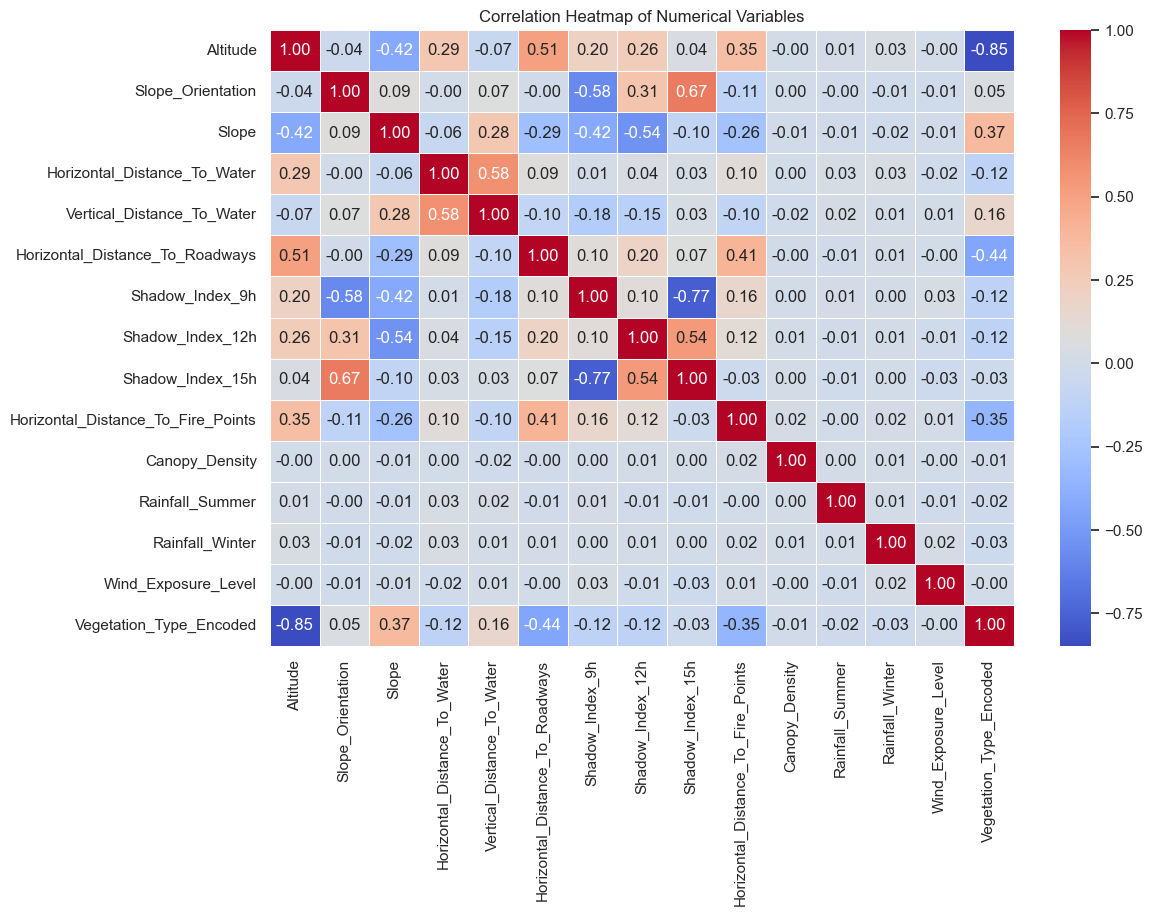

In [77]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Convert Vegetation_Type to numerical labels using LabelEncoder
label_encoder = LabelEncoder()
df['Vegetation_Type_Encoded'] = label_encoder.fit_transform(df['Vegetation_Type'])

# List of numerical columns to include in the correlation heatmap
numerical_columns = [
    'Altitude', 'Slope_Orientation', 'Slope', 
    'Horizontal_Distance_To_Water', 'Vertical_Distance_To_Water', 
    'Horizontal_Distance_To_Roadways', 'Shadow_Index_9h', 
    'Shadow_Index_12h', 'Shadow_Index_15h', 
    'Horizontal_Distance_To_Fire_Points', 'Canopy_Density', 
    'Rainfall_Summer', 'Rainfall_Winter', 'Wind_Exposure_Level',
    'Vegetation_Type_Encoded'  # Include encoded Vegetation_Type
]

# Compute the correlation matrix
corr_matrix = df[numerical_columns].corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Numerical Variables')
plt.show()


While most of these scatter plots do not reveal substantial differences across the variables for different Vegetation Types, we can observe that the Altitude vs Vegetation Type plot stands out with the most noticeable variation. Vegetation Types 1 and 2 seem to have similar altitudes, whereas Vegetation Type 3 is distinctly associated with a lower altitude range. This suggests that Altitude may be an important factor differentiating Vegetation Type 3 from the others.

For the other variables, such as Slope Orientation, Slope, and various Shadow Index values, the distributions are relatively similar across the vegetation types, offering less informative differentiation.

Box plots for comparing categorical variables.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


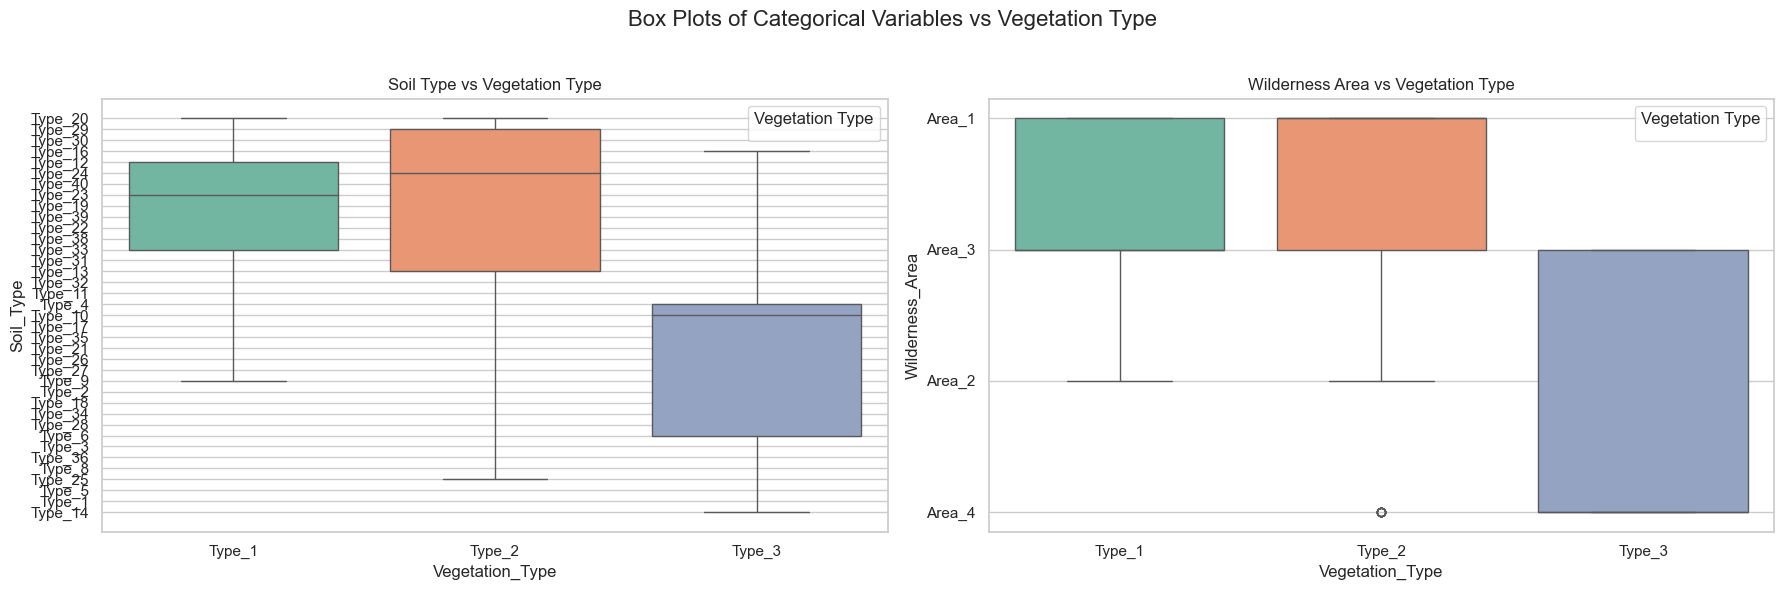

In [78]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style for the visualizations
sns.set(style="whitegrid")

# Plot box plots for categorical variables vs Vegetation_Type
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
fig.suptitle('Box Plots of Categorical Variables vs Vegetation Type', fontsize=16)

# Box plot for Soil_Type vs Vegetation_Type, colored by Vegetation_Type
sns.boxplot(x='Vegetation_Type', y='Soil_Type', data=df, ax=axes[0], palette='Set2', hue='Vegetation_Type', legend=False)
axes[0].set_title('Soil Type vs Vegetation Type')

# Box plot for Wilderness_Area vs Vegetation_Type, colored by Vegetation_Type
sns.boxplot(x='Vegetation_Type', y='Wilderness_Area', data=df, ax=axes[1], palette='Set2', hue='Vegetation_Type', legend=False)
axes[1].set_title('Wilderness Area vs Vegetation Type')

# Adjust the legend
axes[0].legend(title='Vegetation Type', loc='upper right')
axes[1].legend(title='Vegetation Type', loc='upper right')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In the graphs, we observe the relationship between Soil Type and Vegetation Type. The first two vegetation types (Type 1 and Type 2) show similar distributions for the various soil types. However, Vegetation Type 3 exhibits a distinct soil type distribution, indicating that it occurs in areas with different soil characteristics.

For the Wilderness Area vs Vegetation Type plot, we see that Vegetation Types 1 and 2 share similar wilderness areas (Areas 1, 2, and 3). In contrast, Vegetation Type 3 appears to be predominantly associated with Area 4, suggesting a different wilderness distribution compared to the other vegetation types.

# Tryout LR all variables

Accuracy: 0.9974293059125964
Confusion Matrix:
[[666   0   0]
 [  0 384   4]
 [  0   0 502]]
Classification Report:
              precision    recall  f1-score   support

      Type_1       1.00      1.00      1.00       666
      Type_2       1.00      0.99      0.99       388
      Type_3       0.99      1.00      1.00       502

    accuracy                           1.00      1556
   macro avg       1.00      1.00      1.00      1556
weighted avg       1.00      1.00      1.00      1556



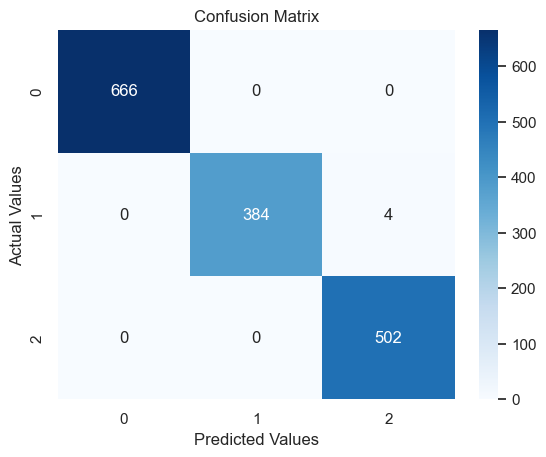

In [93]:
# Step 1: Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Step 2: Load your dataset (adjust the file path as needed)
# Step 3: Prepare the data
# Separate target variable (Vegetation_Type) and features
X = df.drop('Vegetation_Type', axis=1)
y = df['Vegetation_Type']

# Convert categorical variables into dummy variables
X = pd.get_dummies(X, drop_first=True)

# Step 4: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 5: Feature Scaling (Standardize the data)
scaler =  MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Step 6: Apply Logistic Regression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

# Step 7: Make predictions on the test data
y_pred = logreg.predict(X_test)

# Step 8: Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

# Step 9: Visualize the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()


Accuracy: 0.845708775313404
Confusion Matrix:
[[384  56   3]
 [ 76 168  23]
 [  0   2 325]]
Classification Report:
              precision    recall  f1-score   support

      Type_1       0.83      0.87      0.85       443
      Type_2       0.74      0.63      0.68       267
      Type_3       0.93      0.99      0.96       327

    accuracy                           0.85      1037
   macro avg       0.83      0.83      0.83      1037
weighted avg       0.84      0.85      0.84      1037



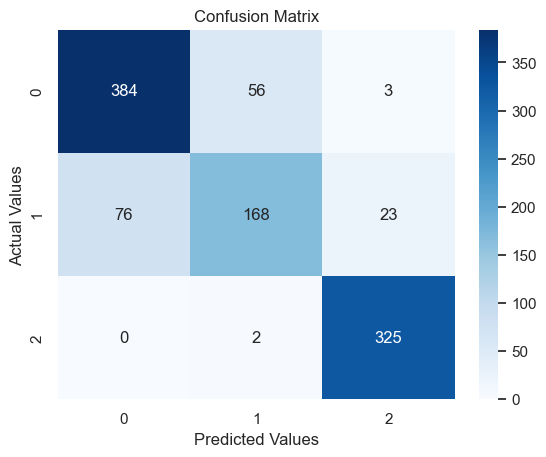

In [80]:
# Step 1: Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is your dataset, modify the below line to load your actual dataset
# df = pd.read_csv('your_dataset.csv')

# Step 2: Select both numerical and categorical features
numerical_features = ['Altitude', 'Slope_Orientation', 'Horizontal_Distance_To_Roadways',
                      'Shadow_Index_9h', 'Shadow_Index_12h' 
                      
                      #, 'Shadow_Index_15h',
                      #'Rainfall_Summer', 'Rainfall_Winter', 'Wind_Exposure_Level'
                      ]

categorical_features = ['Soil_Type', 'Wilderness_Area']  # Include your categorical columns

# Combine numerical and categorical features
selected_features = numerical_features + categorical_features

# Step 3: Separate features and target variable
X = df[selected_features]
y = df['Vegetation_Type']

# Step 4: Convert categorical variables into dummy variables (one-hot encoding)
X = pd.get_dummies(X, drop_first=True)

# Step 5: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 6: Feature Scaling (Standardize the numerical data)
scaler = MinMaxScaler()
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])  # Scale only numerical features
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

# Step 7: Apply Logistic Regression
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)

# Step 8: Make predictions on the test data
y_pred = logreg.predict(X_test)

# Step 9: Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

# Step 10: Visualize the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()


Accuracy: 0.8360655737704918
Confusion Matrix:
[[375  62   6]
 [ 72 167  28]
 [  0   2 325]]
Classification Report:
              precision    recall  f1-score   support

      Type_1       0.84      0.85      0.84       443
      Type_2       0.72      0.63      0.67       267
      Type_3       0.91      0.99      0.95       327

    accuracy                           0.84      1037
   macro avg       0.82      0.82      0.82      1037
weighted avg       0.83      0.84      0.83      1037



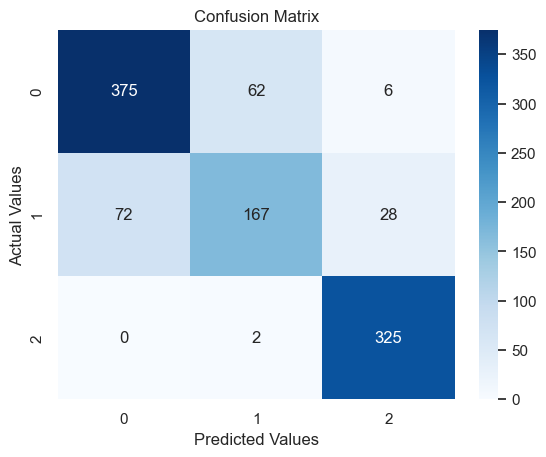

In [81]:
# Step 1: Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

y = df['Vegetation_Type']

# Define numerical and categorical features
numerical_features = ['Altitude', 'Slope_Orientation', 'Horizontal_Distance_To_Roadways',
                      'Shadow_Index_9h', 'Shadow_Index_12h']

categorical_features = ['Soil_Type', 'Wilderness_Area']  # Include your categorical columns

# Step 3: Convert categorical variables into dummy variables
# It's important to include only the selected features after converting to dummy
X = pd.get_dummies(df[numerical_features + categorical_features], drop_first=True)

# Step 4: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 5: Feature Scaling (Standardize the data)
scaler = MinMaxScaler()  # Create a StandardScaler object
X_train = scaler.fit_transform(X_train)  # Fit and transform the training data
X_test = scaler.transform(X_test)  # Only transform the test data

# Step 6: Apply Linear Discriminant Analysis
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)

# Step 7: Make predictions on the test data
y_pred = lda.predict(X_test)

# Step 8: Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

# Step 9: Visualize the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()


Accuracy: 0.7078109932497589
Confusion Matrix:
[[339  75  29]
 [136  69  62]
 [  0   1 326]]
Classification Report:
              precision    recall  f1-score   support

      Type_1       0.71      0.77      0.74       443
      Type_2       0.48      0.26      0.33       267
      Type_3       0.78      1.00      0.88       327

    accuracy                           0.71      1037
   macro avg       0.66      0.67      0.65      1037
weighted avg       0.67      0.71      0.68      1037



c:\Users\gardi\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


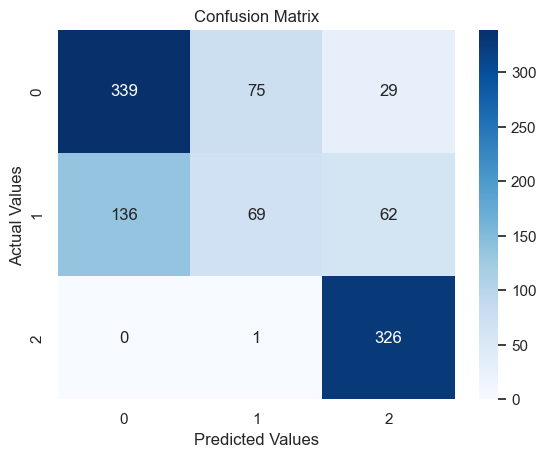

In [91]:
# Step 1: Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis  # Import QDA instead of LDA
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is already defined and loaded with your dataset
y = df['Vegetation_Type']

# Define numerical and categorical features
numerical_features = ['Altitude', 'Slope_Orientation', 'Horizontal_Distance_To_Roadways',
                      'Shadow_Index_9h', 'Shadow_Index_12h']

categorical_features = ['Soil_Type', 'Wilderness_Area']  # Include your categorical columns

# Step 3: Convert categorical variables into dummy variables
# It's important to include only the selected features after converting to dummy
X = pd.get_dummies(df[numerical_features + categorical_features], drop_first=True)

# Step 4: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 5: Feature Scaling (Standardize the data)
scaler = MinMaxScaler()  # Create a MinMaxScaler object
X_train = scaler.fit_transform(X_train)  # Fit and transform the training data
X_test = scaler.transform(X_test)  # Only transform the test data

# Step 6: Apply Quadratic Discriminant Analysis
qda = QuadraticDiscriminantAnalysis()  # Create a QDA object
qda.fit(X_train, y_train)  # Fit the QDA model to the training data

# Step 7: Make predictions on the test data
y_pred = qda.predict(X_test)

# Step 8: Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

# Step 9: Visualize the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()


## Preparing data for models

In [83]:
def preprocess_data(df, target, numerical_features, categorical_features):
    # Combine numerical and categorical features
    selected_features = numerical_features + categorical_features
    
    # Separate features and target variable
    X = df[selected_features]
    y = df[target]
    
    # Convert categorical variables into dummy variables
    X = pd.get_dummies(X, drop_first=True)
    
    # Scale numerical features
    scaler = MinMaxScaler()
    X[numerical_features] = scaler.fit_transform(X[numerical_features])

    return X, y

## Holdout validation

In [84]:
def holdout_validation(model, X, y, test_size=0.2):
    # Train-Test Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    
    # Fit the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)

    print(f"Holdout Validation Accuracy: {accuracy}")
    print("Confusion Matrix:")
    print(conf_matrix)
    print("Classification Report:")
    print(class_report)
    
    # Plot confusion matrix
    # sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    # plt.title('Confusion Matrix (Holdout Validation)')
    # plt.ylabel('Actual Values')
    # plt.xlabel('Predicted Values')
    # plt.show()

## Cross validation

In [85]:
def k_fold_cross_validation(model, X, y, k=5):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    scores = cross_val_score(model, X, y, cv=kf)
    print(f"K-Fold Cross Validation (k={k}) Accuracy Scores: {scores}")
    print(f"Mean Accuracy: {np.mean(scores)}")

## LOOCV Cross validation

In [86]:
def loocv_cross_validation(model, X, y, max_samples=None):
    loo = LeaveOneOut()
    
    # Use max_samples to limit the number of LOOCV evaluations
    if max_samples is not None and max_samples < len(X):
        indices = np.random.choice(len(X), max_samples, replace=False)
        X = X.iloc[indices]
        y = y.iloc[indices]

    accuracies = []
    
    for train_index, test_index in loo.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)

    print(f"LOOCV Accuracy: {np.mean(accuracies):.4f}")

## Bootstrap evaluation

In [87]:
def bootstrap_evaluation(model, X, y, n_iterations=1000):
    n_size = int(len(X) * 0.9)  # Use 90% of the data for bootstrap sample
    scores = []

    for i in range(n_iterations):
        # Generate a bootstrap sample
        X_train, y_train = resample(X, y, n_samples=n_size, random_state=i)
        
        # Fit the model on the bootstrap sample
        model.fit(X_train, y_train)
        
        # Test on the out-of-bag data (remaining 10%)
        X_test, y_test = X.drop(X_train.index), y.drop(y_train.index)
        y_pred = model.predict(X_test)
        
        # Calculate accuracy
        accuracy = accuracy_score(y_test, y_pred)
        scores.append(accuracy)

    print(f"Bootstrap Mean Accuracy: {np.mean(scores)}")
    print(f"Bootstrap Standard Deviation: {np.std(scores)}")

## Pipeline for running resempling in models

In [88]:
def run_cross_validation_pipeline(df, model, target='Vegetation_Type', use_loocv=False, use_bootstrap=False):
    # Define numerical and categorical features
    numerical_features = ['Altitude', 'Slope_Orientation', 'Horizontal_Distance_To_Roadways', 
                          'Shadow_Index_9h', 'Shadow_Index_12h']
    categorical_features = ['Soil_Type', 'Wilderness_Area']
    
    # Step 1: Preprocess the data
    X, y = preprocess_data(df, target, numerical_features, categorical_features)

    
    # Step 2: Perform Holdout Validation
    print("Holdout Validation Results:")
    holdout_validation(model, X, y, test_size=0.2)
    
    # Step 3: Perform K-Fold Cross Validation
    print("\nK-Fold Cross Validation Results (k=5):")
    k_fold_cross_validation(model, X, y, k=5)
    
    print("\nK-Fold Cross Validation Results (k=10):")
    k_fold_cross_validation(model, X, y, k=10)
    
    # Step 4: Optionally Perform Leave-One-Out Cross Validation (LOOCV)
    if use_loocv:
        print("\nLOOCV Results:")
        loocv_cross_validation(model, X, y, max_samples=100)
    
    # Step 5: Optionally Perform Bootstrap Evaluation
    if use_bootstrap:
        print("\nBootstrap Evaluation Results:")
        bootstrap_evaluation(model, X, y, n_iterations=100)  # Limit Bootstrap iterations


### Trying the types

In [89]:
logreg_model = LogisticRegression(max_iter=1000)
lda_model = LinearDiscriminantAnalysis()
qda_model = QuadraticDiscriminantAnalysis()
# Example usage without LOOCV and Bootstrap (default)
#run_cross_validation_pipeline(df, logreg_model)

# Example usage with LOOCV and Bootstrap (optional)
run_cross_validation_pipeline(df, logreg_model, use_loocv=True, use_bootstrap=True)

run_cross_validation_pipeline(df, lda_model, use_loocv=True, use_bootstrap=True)

run_cross_validation_pipeline(df, qda_model, use_loocv=True, use_bootstrap=True)




Holdout Validation Results:
Holdout Validation Accuracy: 0.845708775313404
Confusion Matrix:
[[384  56   3]
 [ 76 168  23]
 [  0   2 325]]
Classification Report:
              precision    recall  f1-score   support

      Type_1       0.83      0.87      0.85       443
      Type_2       0.74      0.63      0.68       267
      Type_3       0.93      0.99      0.96       327

    accuracy                           0.85      1037
   macro avg       0.83      0.83      0.83      1037
weighted avg       0.84      0.85      0.84      1037


K-Fold Cross Validation Results (k=5):
K-Fold Cross Validation (k=5) Accuracy Scores: [0.84570878 0.81388621 0.82545805 0.82545805 0.81467181]
Mean Accuracy: 0.8250365808707179

K-Fold Cross Validation Results (k=10):
K-Fold Cross Validation (k=10) Accuracy Scores: [0.83236994 0.85549133 0.8150289  0.79961464 0.82625483 0.84362934
 0.83783784 0.81467181 0.81467181 0.81467181]
Mean Accuracy: 0.8254242268693137

LOOCV Results:
LOOCV Accuracy: 0.6900

Boo

c:\Users\gardi\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\gardi\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\gardi\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\gardi\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\gardi\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\gardi\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\gardi\anaconda3\Lib\site-

K-Fold Cross Validation (k=10) Accuracy Scores: [0.73988439 0.73603083 0.76300578 0.71098266 0.73359073 0.6969112
 0.75868726 0.75096525 0.71042471 0.72972973]
Mean Accuracy: 0.7330212541195201

LOOCV Results:


c:\Users\gardi\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\gardi\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\gardi\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\gardi\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\gardi\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\gardi\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\gardi\anaconda3\Lib\site-

LOOCV Accuracy: 0.6800

Bootstrap Evaluation Results:


c:\Users\gardi\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\gardi\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\gardi\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\gardi\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\gardi\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\gardi\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\gardi\anaconda3\Lib\site-

Bootstrap Mean Accuracy: 0.7243202032679531
Bootstrap Standard Deviation: 0.021854988509127357


c:\Users\gardi\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\gardi\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\gardi\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\gardi\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\gardi\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\gardi\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\gardi\anaconda3\Lib\site-

In [90]:
from sklearn.metrics import accuracy_score, f1_score

def compare_models(models, X_train, X_test, y_train, y_test):
    comparison_results = []
    
    for name, model in models:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        comparison_results.append({'Model': name, 'Accuracy': accuracy, 'F1 Score': f1})

    return pd.DataFrame(comparison_results)

# Example usage
models = [('Logistic Regression', logreg_model), ('LDA', lda_model), ('QDA', qda_model)]
compare_models(models, X_train, X_test, y_train, y_test)


c:\Users\gardi\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


,Model,Accuracy,F1 Score
0,Logistic Regression,0.845709,0.841117
1,LDA,0.836066,0.831462
2,QDA,0.707811,0.678090
